In [ ]:
# SETUP
import random
import numpy as np
import csv
import tensorflow as tf
import tensorflow.keras as keras
import itertools
import math
import time
import tensorflow_probability as tfp
import functools

pi = math.pi

In [ ]:
# GENERATING DATA (AND WRITE TO .CSV)
def flatArr(x):
    y = []
    for row in x:
        for el in row:
            y.append(el)
    return np.array(y).flatten()

def sampling(x_range, y_range, int_size, bound_size):
    int_x = np.random.uniform(x_range[0], x_range[1], int_size)
    int_y = np.random.uniform(y_range[0], y_range[1], int_size)
    Boundary_points = []
    for i in range(bound_size):
        random_point = [random.uniform(x_range[0], x_range[1]), random.uniform(y_range[0], y_range[1])]
        random_index = random.randint(0,1)
        if random_index == 0:
            random_value = random.choice([x_range[0], x_range[1]])
        else:
            random_value = random.choice([y_range[0], y_range[1]])
        random_point[random_index] = random_value
        Boundary_points.append(random_point)
    bound_x = np.array(Boundary_points)[:, 0]
    bound_y = np.array(Boundary_points)[:, 1]
    # delta_t = t_range[1]/t_size
    # int_x_t = np.array([])
    # int_y_t = np.array([])
    # bound_x_t = np.array([])
    # bound_y_t = np.array([])
    # t = []
    # tb = []
    # for i in range(t_size):
    #     t.append([round(t_range[0]+(i+1)*delta_t,6) for e in range(int_x.size)])
    #     int_x_t = np.concatenate((int_x_t, int_x))
    #     int_y_t = np.concatenate((int_y_t, int_y))
    #     tb.append([round(t_range[0]+(i+1)*delta_t,6) for e in range(bound_x.size)])
    #     bound_x_t = np.concatenate((bound_x_t, bound_x))
    #     bound_y_t = np.concatenate((bound_y_t, bound_y))
    # t = flatArr(t)
    # tb = flatArr(tb)
    return int_x, int_y, bound_x, bound_y

# training data
N_train = 50;        # number of points
nu = 0.025
lambda_ = 1/(2*nu)-np.sqrt(1/(4*nu*nu)+4*pi*pi)
int_x, int_y, bound_x, bound_y = sampling([-0.5, 0.5], [-0.5, 0.5], N_train, N_train)

# write training data to .csv file
# with open('/content/drive/MyDrive/Papers/Code (chung)/data_train.csv', mode='w') as f:
with open('data_train.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(N_train):
        u_b = 1-np.exp(lambda_*bound_x[i])*np.cos(2*pi*bound_y[i])
        v_b = lambda_/(2*pi)*np.exp(lambda_*bound_x[i])*np.cos(2*pi*bound_y[i])
        csv_writer.writerow([int_x[i], int_y[i], bound_x[i], bound_y[i], u_b, v_b])


# test data
N_test = 100;        # number of points
int_x, int_y, bound_x, bound_y = sampling([-0.5, 0.5], [-0.5, 0.5], N_test, N_test)

# write test data to .csv file
# with open('/content/drive/MyDrive/Papers/Code (chung)/data_test.csv', mode='w') as f:
with open('data_test.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(N_test):
        csv_writer.writerow([int_x[i], int_y[i]])
    for i in range(N_test):
        csv_writer.writerow([bound_x[i], bound_y[i]])

In [ ]:
# READ DATA

# load the dataset
# data_train = np.float32(np.loadtxt('/content/drive/MyDrive/Papers/Code (chung)/data_train.csv', delimiter=','))
# data_test = np.float32(np.loadtxt('/content/drive/MyDrive/Papers/Code (chung)/data_test.csv', delimiter=','))

data_train = np.float32(np.loadtxt('data_train.csv', delimiter=','))
data_test = np.float32(np.loadtxt('data_test.csv', delimiter=','))
# # split into datasets
# P_in = dataset[:,0:2]
# P_b = dataset[:,2:4]

# # Load NumPy arrays with tf.data.Dataset
# P_in = tf.data.Dataset.from_tensor_slices(P_in)
# P_b = tf.data.Dataset.from_tensor_slices(P_b)

# # Shuffle and batch the datasets
# BATCH_SIZE=32
# SHUFFLE_BUFFER_SIZE=100

# P_in = P_in.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# P_b = P_b.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# BUILD NETWORK

# dimension of input and output
in_dim = 2
out_dim = 3

# number of neurons on each layer
nn = [16, 16, 16, 16, 16]

# input layer
inputs = keras.Input(shape=(in_dim,), name='points')

# hidden layers
hidden = keras.layers.Dense(nn[0], activation='tanh', name='hidden_1')(inputs)
for i in range(len(nn)-1):
    hidden = keras.layers.Dense(nn[i+1], activation='tanh', name='hidden_' + str(i+2))(hidden)

# output layer
outputs = keras.layers.Dense(out_dim, activation='linear', name="u")(hidden)

# create network
PDEmodel = keras.Model(inputs=inputs, outputs=outputs, name='chorinvorte')

# show network details
PDEmodel.summary()

Model: "chorinvorte"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 16)                48        
_________________________________________________________________
hidden_2 (Dense)             (None, 16)                272       
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                272       
_________________________________________________________________
hidden_4 (Dense)             (None, 16)                272       
_________________________________________________________________
hidden_5 (Dense)             (None, 16)                272       
_________________________________________________________________
u (Dense)                    (None, 3)                 

In [ ]:
# TRAINING

# GRAD U
def grad_u(X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        uvp = PDEmodel(X)
        u = uvp[:, 0]
        v = uvp[:, 1]
        p = uvp[:, 2]

    u_x = tape.gradient(u, X)[:, 0]
    u_y = tape.gradient(u, X)[:, 1]
    v_x = tape.gradient(v, X)[:, 0]
    v_y = tape.gradient(v, X)[:, 1]
    p_x = tape.gradient(p, X)[:, 0]
    p_y = tape.gradient(p, X)[:, 1]

    return u, v, u_x, u_y, v_x, v_y, p_x, p_y

# return 1D weights
def get_weights():
    w = []
    for layer in PDEmodel.layers[1:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    return w

# get size of weights in each model's layer
sizes_w = []
sizes_b = []
for layer in PDEmodel.layers[1:]:
    weights_biases = layer.get_weights()
    sizes_w.append(weights_biases[0].flatten().size)
    sizes_b.append(weights_biases[1].size)

# convert 1D weights to multi dimension weights in each model's layer
def set_weights(w):
    for i, layer in enumerate(PDEmodel.layers[1:]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)

losses_hist = []
def train(epochs, BATCH_SIZE=50, SHUFFLE_BUFFER_SIZE=100, optimizer = 'adam'):
    nu = 0.025
    # split into datasets
    P_in = data_train[:,0:2]
    # P_in_i = P_in[0:N_train]
    # P_in = P_in[N_train:]
    P_b = data_train[:,2:4]
    U_b = data_train[:, 4]
    V_b = data_train[:, 5]
    # P_b_i = P_b[0:N_train]
    # P_b = P_b[N_train:]
    # P_i = np.concatenate((P_in_i, P_b_i))
    # P_i_tf = tf.convert_to_tensor(P_i, dtype=tf.float32)
    # CHOOSE OPTIMIZER
    if (optimizer == 'adam'):
        optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
        # Load NumPy arrays with tf.data.Dataset
        P_in = tf.data.Dataset.from_tensor_slices(P_in)
        P_b = tf.data.Dataset.from_tensor_slices(P_b)
        # Shuffle and batch the datasets
        P_in = P_in.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
        P_b = P_b.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
        # for loop epochs
        for epoch in range(epochs):
            start_epoch = time.time()
            # for loop iteration (all batches)
            loss = [0]
            for (P_in_batch, P_b_batch) in itertools.zip_longest(P_in, P_b):
                # interior loss
                with tf.GradientTape() as tape:
                    with tf.GradientTape(persistent=True) as tape1:
                        tape1.watch(P_in_batch)
                        u, v, u_x, u_y, v_x, v_y, p_x, p_y = grad_u(P_in_batch)

                    # u_xx and u_yy
                    u_xx = tape1.gradient(u_x, P_in_batch)[:,0]
                    u_yy = tape1.gradient(u_y, P_in_batch)[:,1]
                    v_xx = tape1.gradient(v_x, P_in_batch)[:,0]
                    v_yy = tape1.gradient(v_y, P_in_batch)[:,1]
                    
                    # loss_in_batch
                    f_u = -nu*(u_xx + u_yy) + u*u_x + v*u_y + p_x
                    f_v = -nu*(v_xx + v_yy) + u*v_x + v*v_y + p_y
                    div_u = u_x + v_y
                    loss_in_batch = tf.reduce_mean(tf.math.square(f_u)) + \
                                    tf.reduce_mean(tf.math.square(f_v)) + \
                                    tf.reduce_mean(tf.math.square(div_u))
                    
                    # loss_b_batch
                    uvp = PDEmodel(P_b_batch)
                    u = uvp[:,0]
                    v = uvp[:,1]
                    loss_b_batch = tf.reduce_mean(tf.math.square(u)) + \
                                   tf.reduce_mean(tf.math.square(v))

                    # total loss
                    loss_batch = loss_in_batch + loss_b_batch
                
                # update paremeters
                grads = tape.gradient(loss_batch, PDEmodel.weights)
                optimizer.apply_gradients(zip(grads, PDEmodel.weights))
                
                # add loss_batch to loss
                loss += loss_batch
            
            loss = loss/len(list(P_in))
            print("[%4s] loss = %12.5f \t %4.3fs" % (epoch, loss, time.time() - start_epoch))
            losses_hist.append(loss.numpy())

            # break condition
            # if (epoch > 200):
            #     if (losses_hist[epoch][0]/losses_hist[epoch-100][0] > 0.9):
            #         break

    if (optimizer == 'l-bfgs'):
        P_in = tf.convert_to_tensor(P_in, dtype=tf.float32)
        P_b = tf.convert_to_tensor(P_b, dtype=tf.float32)
        U_b = tf.convert_to_tensor(U_b, dtype=tf.float32)
        V_b = tf.convert_to_tensor(V_b, dtype=tf.float32)
        def function_factory(P_in, P_b, U_b, V_b):

            def loss_grad(weights):
                start_epoch = time.time()
                with tf.GradientTape() as tape:
                    with tf.GradientTape(persistent=True) as tape1:
                        set_weights(weights)
                        tape1.watch(P_in)
                        u, v, u_x, u_y, v_x, v_y, p_x, p_y = grad_u(P_in)

                    # u_xx and u_yy
                    u_xx = tape1.gradient(u_x, P_in)[:,0]
                    u_yy = tape1.gradient(u_y, P_in)[:,1]
                    v_xx = tape1.gradient(v_x, P_in)[:,0]
                    v_yy = tape1.gradient(v_y, P_in)[:,1]

                    # loss_in
                    # - pi/2*tf.math.sin(2*pi*P_in[:,1])*tf.math.exp(-4*pi*pi*P_in[:,0]/Re)
                    # - pi/2*tf.math.sin(2*pi*P_in[:,2])*tf.math.exp(-4*pi*pi*P_in[:,0]/Re)
                    f_u = -nu*(u_xx + u_yy) + u*u_x + v*u_y + p_x
                    f_v = -nu*(v_xx + v_yy) + u*v_x + v*v_y + p_y
                    div_u = u_x + v_y
                    loss_in = tf.reduce_mean(tf.math.square(f_u)) + \
                              tf.reduce_mean(tf.math.square(f_v)) + \
                              tf.reduce_mean(tf.math.square(div_u))

                    # loss_b
                    uvp = PDEmodel(P_b)
                    u = uvp[:,0]
                    v = uvp[:,1]
                    loss_b = tf.reduce_mean(tf.math.square(u - U_b)) + \
                             tf.reduce_mean(tf.math.square(v - V_b))

                    # total loss
                    loss = loss_in + loss_b
                    print("loss = %12.5f \t %4.3fs" % (loss, time.time() - start_epoch))
                    losses_hist.append(loss.numpy())
                grad = tape.gradient(loss, PDEmodel.weights)
                grad_1D = []
                for g in grad:
                    grad_1D.append(tf.reshape(g, [-1]))
                grad_1D = tf.concat(grad_1D, 0)
                return loss, grad_1D
            return loss_grad
        # update paremeters

        func = function_factory(P_in, P_b, U_b, V_b)
        # add loss_batch to loss
        tfp.optimizer.lbfgs_minimize(func,
            tf.convert_to_tensor(get_weights(), dtype=tf.float32),
            max_iterations=epochs)
        # set_weights(result)
        # print(result)

        # start = get_weights()
        # @tf.function
        # def opt_with_bfgs():
        #     return tfp.optimizer.lbfgs_minimize(
        #         loss_grad,
        #         initial_position=tf.convert_to_tensor(start, dtype=tf.float32),
        #         max_iterations=epochs)

        # results = run(opt_with_bfgs)
        # print('BFGS Results')
        # print('Converged:', results.converged)
        # print('Location of the minimum:', results.position)
        # print('Number of iterations:', results.num_iterations)
    

    

loss =      3.54307 	 0.174s
loss =     23.08813 	 0.031s
loss =     15.56380 	 0.036s
loss =      6.18021 	 0.031s
loss =      4.85340 	 0.030s
loss =      2.85582 	 0.038s
loss =      2.70564 	 0.034s
loss =      1.34951 	 0.037s
loss =      1.34494 	 0.032s
loss =      0.60745 	 0.044s
loss =      6.42272 	 0.030s
loss =      0.60870 	 0.031s
loss =      0.58762 	 0.032s
loss =      0.60536 	 0.031s
loss =      0.57583 	 0.031s
loss =      0.56031 	 0.038s
loss =      0.56656 	 0.044s
loss =      0.55106 	 0.038s
loss =      0.54741 	 0.032s
loss =      0.55804 	 0.036s
loss =      0.54631 	 0.033s
loss =      0.54466 	 0.031s
loss =      0.54283 	 0.031s
loss =      0.54261 	 0.032s
loss =      0.54174 	 0.035s
loss =      0.55473 	 0.031s
loss =      0.54173 	 0.031s
loss =      0.54129 	 0.031s
loss =      0.54323 	 0.031s
loss =      0.54120 	 0.032s
loss =      0.54103 	 0.043s
loss =      0.54057 	 0.039s
loss =      0.54351 	 0.039s
loss =      0.54044 	 0.034s
loss =      0.

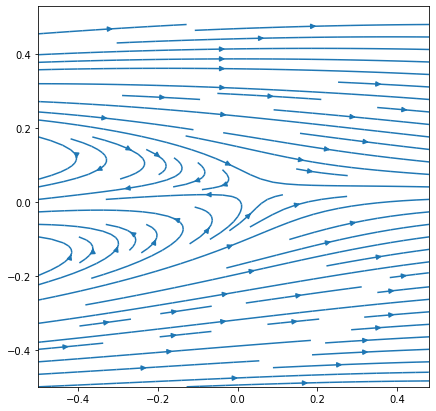

In [ ]:
# train(200, optimizer='adam')
train(500, optimizer='l-bfgs')
def u(network,x,y):
    z = tf.convert_to_tensor([[x, y]])
    uvp = network(z)
    u = float(uvp[:,0])
    v = float(uvp[:,1])
    return u, v

def exact_sol(x,y):
    nu = 0.025
    lambda_ = 1/(2*nu)-np.sqrt(1/(4*nu*nu)+4*pi*pi)
    u = 1-np.exp(lambda_*x)*np.cos(2*pi*y)
    v = lambda_/(2*pi)*np.exp(lambda_*x)*np.cos(2*pi*y)
    return u, v

P = data_test

err = 0
for i in range(len(P)):
    u_pred, v_pred = u(PDEmodel, P[i][0], P[i][1])
    u_e, v_e = exact_sol(P[i][0], P[i][1])
    err += (u_pred - u_e)**2 + (v_pred - v_e)**2
    # if (i < 1000):
    # print(u_e)
    # print(u_pred)
    # print("-----")

L2 = math.sqrt(err/len(P))
print("L2 = ", L2)

import matplotlib.pyplot as plt 
Y, X = np.mgrid[-0.5:0.5:0.02, -0.5:0.5:0.02] 
Y = Y.flatten()
X = X.flatten()
with open('data_simulation.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(X.size):
        csv_writer.writerow([X[i], Y[i]])

P = np.float32(np.loadtxt('data_simulation.csv', delimiter=','))
P = tf.convert_to_tensor(P, dtype=tf.float32)
UVP = PDEmodel(P)
Y, X = np.mgrid[-0.5:0.5:0.02, -0.5:0.5:0.02]  
U = np.array(UVP[:,0]).flatten()
V = np.array(UVP[:,1]).flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 